## Classification leveraging Amazon SageMaker & S3

Performing a classification task on the an employee dataset, training an XGBoost decision tree model to predict a given person's salary (the `WAGP` column) - labeling instances into multiple bins.<br>

- Exploratory Data Analysis on the given dataset
- Save preprocessed datasets to Amazon S3
- Use the Amazon Sagemaker platform to train an XGBoost model
- Evaluate the model on the test set
- Perform hyperparameter tuning on the XGBoost model

### 1. Import packages and Get Amazon IAM execution role & instance region

In [1]:
import os, sagemaker
from sagemaker import get_execution_role
from sklearn.model_selection import train_test_split

In [2]:
# Define IAM role- this will be necessary when defining your model
iam_role = get_execution_role()

# Set SageMaker session handle
sess = sagemaker.Session()

# set the region of the instance and get a reference to the client
region = sess.boto_session.region_name

bucket = sess.default_bucket()  # this could also be a hard-coded bucket name

print('Using bucket ' + bucket)
print("Success - the SageMaker instance is in the " + region + " region")

Using bucket sagemaker-us-west-2-932696182434
Success - the SageMaker instance is in the us-west-2 region


### 2. Read data.

In [3]:
import pandas as pd
import pickle

# Read data from the S3 bucket
file_path = "s3://willquinn-emr01/misc/person_records_merged.csv"

df = pd.read_csv(file_path)
df.head()

,SERIALNO,SPORDER,PUMA,ST,ADJINC,AGEP,CIT,CITWP,COW,DDRS,...,RACWHT,RC,SFN,SFR,SOCP,VPS,WAOB,FHINS3C,FHINS4C,FHINS5C
0,84,1,2600,1,1007549,19,1,NaN,NaN,2.0,...,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
1,154,1,2500,1,1007549,55,1,NaN,1.0,2.0,...,0,0,NaN,NaN,411011,NaN,1,NaN,NaN,NaN
2,154,2,2500,1,1007549,56,1,NaN,6.0,2.0,...,0,0,NaN,NaN,493050,NaN,1,NaN,NaN,NaN
3,154,3,2500,1,1007549,21,1,NaN,NaN,2.0,...,0,0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
4,154,4,2500,1,1007549,21,1,NaN,NaN,1.0,...,0,0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN


### Description of Columns

There are lots of columns in the original dataset. However, we'll only use the following columns whose descriptions are given below.


AGEP -  Age

COW - Class of worker

WAGP - Wages or salary income past 12 months

JWMNP - Travel time to work

JWTR - Means of transportation to work

MAR - Marital status

PERNP - Total person's earnings

NWAV - Available for work

NWLA - On layoff from work

NWLK - Looking for work

NWAB - Temporary absence from work

SCHL - Educational attainment

WKW - Weeks worked during past 12 months

In [4]:
colNames = ['AGEP', 'COW', 'WAGP', 'JWMNP', 'JWTR', 'MAR', 'PERNP', 'NWAV', 
            'NWLA', 'NWLK', 'NWAB', 'SCHL', 'WKW']

df = df[colNames]

df.head()

,AGEP,COW,WAGP,JWMNP,JWTR,MAR,PERNP,NWAV,NWLA,NWLK,NWAB,SCHL,WKW
0,19,NaN,0.0,NaN,NaN,5,0.0,5.0,2.0,2.0,2.0,19.0,NaN
1,55,1.0,52000.0,30.0,1.0,1,52000.0,5.0,3.0,3.0,3.0,20.0,1.0
2,56,6.0,0.0,NaN,11.0,1,99000.0,5.0,3.0,3.0,3.0,16.0,1.0
3,21,NaN,0.0,NaN,NaN,5,0.0,5.0,2.0,2.0,2.0,19.0,NaN
4,21,NaN,0.0,NaN,NaN,5,0.0,5.0,2.0,2.0,2.0,19.0,NaN


### 3. Filtering data

Find the correlation of the WAGP value with all other features.

In [5]:
# Find the correlation of each of the features with the target variable WAGP


print('Correlations with WAGP:',
'AGEP:', df['WAGP'].corr(df['AGEP']),
'COW:', df['WAGP'].corr(df['COW']),
'JWMNP:', df['WAGP'].corr(df['JWMNP']),
'JWTR:', df['WAGP'].corr(df['JWTR']),
'MAR:', df['WAGP'].corr(df['MAR']),
'PERNP:', df['WAGP'].corr(df['PERNP']),
'NWAV:', df['WAGP'].corr(df['NWAV']),
'NWLA:', df['WAGP'].corr(df['NWLA']),
'NWLK:', df['WAGP'].corr(df['NWLK']),
'NWAB:', df['WAGP'].corr(df['NWAB']),
'SCHL:', df['WAGP'].corr(df['SCHL']),
'WKW:', df['WAGP'].corr(df['WKW']))

Correlations with WAGP: AGEP: -0.034028422159155004 COW: -0.06277891444051867 JWMNP: 0.10563870072567623 JWTR: -0.026631012265713183 MAR: -0.16781655340177812 PERNP: 0.9507294493107296 NWAV: 0.11007110010819092 NWLA: 0.33443922964541745 NWLK: 0.3253553252937488 NWAB: 0.3238221145931637 SCHL: 0.29196669730890873 WKW: -0.3039528417971109


In [6]:
# Since PERNP is highly correlated with WAGP, we remove that column from the dataset.


colNames = ['AGEP', 'COW', 'WAGP', 'JWMNP', 'JWTR', 'MAR', 'NWAV', 'NWLA', 'NWLK', 'NWAB', 'SCHL', 'WKW']

df = df[colNames]
df.head()

,AGEP,COW,WAGP,JWMNP,JWTR,MAR,NWAV,NWLA,NWLK,NWAB,SCHL,WKW
0,19,NaN,0.0,NaN,NaN,5,5.0,2.0,2.0,2.0,19.0,NaN
1,55,1.0,52000.0,30.0,1.0,1,5.0,3.0,3.0,3.0,20.0,1.0
2,56,6.0,0.0,NaN,11.0,1,5.0,3.0,3.0,3.0,16.0,1.0
3,21,NaN,0.0,NaN,NaN,5,5.0,2.0,2.0,2.0,19.0,NaN
4,21,NaN,0.0,NaN,NaN,5,5.0,2.0,2.0,2.0,19.0,NaN


In [7]:
print("WAGP statistics:")

df.WAGP.describe()

WAGP statistics:


count    2.582042e+06
mean     2.565256e+04
std      4.736001e+04
min      0.000000e+00
25%      0.000000e+00
50%      6.000000e+03
75%      3.600000e+04
max      6.600000e+05
Name: WAGP, dtype: float64

### 4. Outlier Removal

Remove outlier rows based on values in the `WAGP` column.

In [8]:
# Selecting the number of standard deviations to set as the upper limit
nStddevs = 3
    
# Finding the mean and standard deviations of the WAGP column
nSamples = len(df)
colName = 'WAGP'

mu = df.WAGP.mean()
sigma = df.WAGP.std()
print('\n{} -- mean:\t{}\n\tstddev:\t{}'.format(colName, mu, sigma))

# Calculating the value of the WAGP upper limit using the calculated mean and standard deviation
upperLim = mu + nStddevs*sigma
print('Removing rows with {} above {}'.format(colName, upperLim))

# Selecting rows using the WAGP upper limit that have been calculated
df_filtered = df[df[colName] < upperLim]
print (nSamples - len(df_filtered), 'rows removed\n')

df_filtered.head(5)


WAGP -- mean:	25652.55809239354
	stddev:	47360.01051275194
Removing rows with WAGP above 167732.58963064937
588315 rows removed



,AGEP,COW,WAGP,JWMNP,JWTR,MAR,NWAV,NWLA,NWLK,NWAB,SCHL,WKW
0,19,NaN,0.0,NaN,NaN,5,5.0,2.0,2.0,2.0,19.0,NaN
1,55,1.0,52000.0,30.0,1.0,1,5.0,3.0,3.0,3.0,20.0,1.0
2,56,6.0,0.0,NaN,11.0,1,5.0,3.0,3.0,3.0,16.0,1.0
3,21,NaN,0.0,NaN,NaN,5,5.0,2.0,2.0,2.0,19.0,NaN
4,21,NaN,0.0,NaN,NaN,5,5.0,2.0,2.0,2.0,19.0,NaN


### 5. Dropping NAs

Drop rows with any nulls in any of the columns.

In [36]:
"""Remove all rows which have any of the variables as NaN."""

labelCol = 'WAGP'

""""These are the features that we'll use - this does not include WAGP."""
featureCols = ['AGEP', 'COW', 'JWMNP', 'JWTR', 'MAR', 'NWAV', 'NWLA', 'NWLK', 'NWAB', 'SCHL', 'WKW'] 

df_cleaned = df_filtered[[labelCol] + featureCols].dropna(how='any')
print("Num rows left: ", len(df_cleaned))

Num rows left:  1282781


### 6. Discretize salary

Convert the WAGP column, into a column with discrete labels so that we can use it as the label column for our classification problem. 

,WAGP,AGEP,COW,JWMNP,JWTR,MAR,NWAV,NWLA,NWLK,NWAB,SCHL,WKW,WAGP_CAT
1,52000.0,55,1.0,30.0,1.0,1,5.0,3.0,3.0,3.0,20.0,1.0,1
5,39000.0,63,3.0,15.0,1.0,3,5.0,3.0,3.0,3.0,21.0,1.0,1
11,90000.0,59,1.0,10.0,1.0,1,1.0,2.0,2.0,2.0,16.0,1.0,2
12,46000.0,56,1.0,45.0,1.0,1,5.0,3.0,3.0,3.0,18.0,1.0,1
16,20000.0,72,4.0,5.0,1.0,1,5.0,3.0,3.0,3.0,21.0,1.0,0


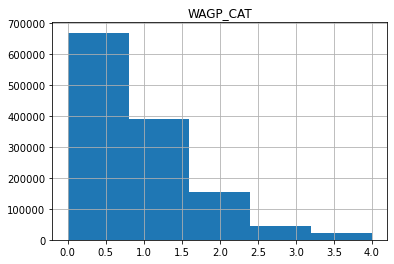

In [37]:
# Categorizing the labels into multiple bins - 5 bins in this case

import matplotlib.pyplot as plt

df_cleaned['WAGP_CAT'] = pd.cut(df_cleaned['WAGP'], bins=5, labels=[0,1,2,3,4])

# Plot a histogram of the WAGP_CAT column
df_cleaned.reset_index(drop = True)
df_cleaned['WAGP_CAT'] = df_cleaned['WAGP_CAT'].astype(int)
ax = df_cleaned.hist(column = 'WAGP_CAT', bins = 5)
#plt.show()


df_cleaned.head(5)

In [38]:
cols = df_cleaned.columns.tolist()
df_cleaned2 = df_cleaned[cols[-1:] + cols[:-1]].drop('WAGP', axis=1)
df_cleaned2.head()

,WAGP_CAT,AGEP,COW,JWMNP,JWTR,MAR,NWAV,NWLA,NWLK,NWAB,SCHL,WKW
1,1,55,1.0,30.0,1.0,1,5.0,3.0,3.0,3.0,20.0,1.0
5,1,63,3.0,15.0,1.0,3,5.0,3.0,3.0,3.0,21.0,1.0
11,2,59,1.0,10.0,1.0,1,1.0,2.0,2.0,2.0,16.0,1.0
12,1,56,1.0,45.0,1.0,1,5.0,3.0,3.0,3.0,18.0,1.0
16,0,72,4.0,5.0,1.0,1,5.0,3.0,3.0,3.0,21.0,1.0


### 7. Splitting data and converting to CSV

In [39]:
# Split train_data and val_data with an 80:20 ratio, and then
# Split the train_data into train_data and test_data in a 90:10 ratio.

# Parameters for train_test_split:
# random_state = 42
# shuffle = True

# train_size = 0.8, test_size = 0.2 for the first split
# train_size = 0.9, test_size = 0.1 for the second split

train_data, val_data = train_test_split(df_cleaned2, test_size = 0.2, random_state = 42, shuffle = True)

train_data, test_data = train_test_split(df_cleaned2, test_size = 0.1, random_state = 42, shuffle = True)

len(train_data), len(val_data), len(test_data)

(1154502, 256557, 128279)

In [41]:
train_data.to_csv('train_data.csv', index=False, header=False)
val_data.to_csv('val_data.csv', index=False, header=False)
test_data.to_csv('test_data.csv', index=False, header=False)

### 8. Save processed data to S3

In [42]:
# Sending data to S3

prefix = "classification-person"
key_prefix = prefix + "/model_data"

trainpath = sess.upload_data(
    path='train_data.csv', bucket=bucket,
    key_prefix=key_prefix)

valpath = sess.upload_data(
    path='val_data.csv', bucket=bucket,
    key_prefix=key_prefix)

testpath = sess.upload_data(
    path='test_data.csv', bucket=bucket,
    key_prefix=key_prefix)

In [43]:
trainpath, valpath, testpath

('s3://sagemaker-us-west-2-932696182434/classification-person/model_data/train_data.csv',
 's3://sagemaker-us-west-2-932696182434/classification-person/model_data/val_data.csv',
 's3://sagemaker-us-west-2-932696182434/classification-person/model_data/test_data.csv')

## 9. Create channels for train and validation data to feed to model

In [45]:
# Setting up data channels for the training, validation, and test data.
# Using the TrainingInput function and pass the s3_data and content_type parameters

s3_input_train = sagemaker.inputs.TrainingInput(s3_data=trainpath, content_type='csv')
s3_input_val = sagemaker.inputs.TrainingInput(s3_data=valpath, content_type='csv')
s3_input_test = sagemaker.inputs.TrainingInput(s3_data=testpath, content_type='csv')


In [46]:
# Setting model output location

output_location = "s3://{}/{}/model".format(bucket,prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://sagemaker-us-west-2-932696182434/classification-person/model


### 10. Building the XGBoost model

In [47]:
# Building the XGBoost model, and setting hyperparameters.

from sagemaker.amazon.amazon_estimator import image_uris
xgb_image = image_uris.retrieve(framework="xgboost", region=region, version='latest')

In [48]:
# Creating an Estimator using sagemaker.estimator.Estimator.
# Passing the xgb_image and the iam_role parameters.

# Using the following values for other parameters:

# instance_count = 1
# instance_type = ml.m5.xlarge
# output_path = output_location
# sagemaker_session = sess 


xgb = sagemaker.estimator.Estimator(xgb_image,
                                          iam_role, 
                                          instance_count=1, 
                                          instance_type='ml.m5.xlarge',
                                          # train_volume_size = 5,
                                          output_path=output_location,
                                          sagemaker_session=sess)


### 11. Set model hyperparameters

In [50]:
# Using the following values for the parameters:

# num_class = 5,
# max_depth = 2,
# min_child_weight = 2,
# early_stopping_rounds=5,
# objective='multi:softmax',
# num_round=100


xgb.set_hyperparameters(max_depth = 2,             
                        objective = "multi:softmax",
                        num_class = 5,
                        min_child_weight = 2,
                        early_stopping_rounds=5,
                        num_round = 100)

### 12. Training the model using train and validation data channels

In [51]:
%%time

xgb.fit({'train': s3_input_train, 'validation': s3_input_val})

2021-03-13 22:41:37 Starting - Starting the training job...
2021-03-13 22:42:00 Starting - Launching requested ML instancesProfilerReport-1615675297: InProgress
......
2021-03-13 22:43:06 Starting - Preparing the instances for training......
2021-03-13 22:44:01 Downloading - Downloading input data
2021-03-13 22:44:01 Training - Downloading the training image..Arguments: train
[2021-03-13:22:44:10:INFO] Running standalone xgboost training.
[2021-03-13:22:44:10:INFO] File size need to be processed in the node: 60.42mb. Available memory size in the node: 7890.27mb
[2021-03-13:22:44:10:INFO] Determined delimiter of CSV input is ','
[22:44:10] S3DistributionType set as FullyReplicated
[22:44:11] 1154502x11 matrix with 12699522 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-03-13:22:44:11:INFO] Determined delimiter of CSV input is ','
[22:44:11] S3DistributionType set as FullyReplicated
[22:44:11] 256557x11 matrix with 2822127 entries loaded from /op

### 13. Deploying model

In [53]:
%%time

# Deploying model so that it can be used for inference.

# Parameters:

# initial_instance_count = 1,
# instance_type = 'ml.t2.medium',
# serializer = sagemaker.serializers.CSVSerializer(),


xgb_predictor = xgb.deploy(initial_instance_count=1,
                                 serializer = sagemaker.serializers.CSVSerializer(),
                                 instance_type='ml.t2.medium')

-------------!CPU times: user 192 ms, sys: 15.9 ms, total: 207 ms
Wall time: 6min 32s


### 14. Testing the model on test data

In [54]:
import numpy as np

test_data_array = test_data.drop(['WAGP_CAT'], axis=1).values #load the data into an array
test_data.head(1)

predictions = xgb_predictor.predict(data=test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:-1], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

y_true = np.array(test_data['WAGP_CAT'].values)
y_pred = predictions_array

(128279,)


### 15. Confusion matrix and classification report

In [55]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[54392 11800   552     5     0]
 [15955 21962  1239     7     1]
 [ 3321 10206  1910     9     3]
 [  622  2800  1246     9     1]
 [  315  1134   777    13     0]]
              precision    recall  f1-score   support

           0       0.73      0.81      0.77     66749
           1       0.46      0.56      0.50     39164
           2       0.33      0.12      0.18     15449
           3       0.21      0.00      0.00      4678
           4       0.00      0.00      0.00      2239

    accuracy                           0.61    128279
   macro avg       0.35      0.30      0.29    128279
weighted avg       0.57      0.61      0.58    128279



#### Delete Endpoint

In [56]:
xgb_predictor.delete_endpoint()

### 16. Hyperparameter tuning

In [60]:
#Hyperparameter tuning on two hyperparameters: min_child_weight, max_depth

from sagemaker.tuner import IntegerParameter


# Define exploration boundaries
hyperparameter_ranges = {'max_depth': IntegerParameter(1, 10),
    'min_child_weight': IntegerParameter(1,10)}

# create Optimizer
Optimizer = sagemaker.tuner.HyperparameterTuner(
    estimator=xgb,
    hyperparameter_ranges=hyperparameter_ranges,
    base_tuning_job_name='XGBoost-Tuner',
    objective_type='Minimize',
    objective_metric_name='validation:merror',
    max_jobs=5,
    max_parallel_jobs=5,
    strategy='Random')

In [61]:
%%time

Optimizer.fit({'train': s3_input_train, 'validation': s3_input_val})

.................................................................................................!
CPU times: user 435 ms, sys: 17.9 ms, total: 453 ms
Wall time: 8min 10s


### 17. Results of tuning job

In [62]:
results = Optimizer.analytics().dataframe()
results

,max_depth,min_child_weight,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,2.0,5.0,XGBoost-Tuner-210313-2257-005-884a7bd8,Completed,0.390132,2021-03-13 22:59:15+00:00,2021-03-13 23:01:36+00:00,141.0
1,1.0,8.0,XGBoost-Tuner-210313-2257-004-d208a723,Completed,0.478054,2021-03-13 22:59:28+00:00,2021-03-13 23:00:45+00:00,77.0
2,2.0,3.0,XGBoost-Tuner-210313-2257-003-b7b0831d,Completed,0.390019,2021-03-13 22:59:38+00:00,2021-03-13 23:01:50+00:00,132.0
3,7.0,1.0,XGBoost-Tuner-210313-2257-002-58b4100d,Completed,0.384421,2021-03-13 22:59:15+00:00,2021-03-13 23:05:03+00:00,348.0
4,5.0,7.0,XGBoost-Tuner-210313-2257-001-cb509ea7,Completed,0.386709,2021-03-13 22:59:30+00:00,2021-03-13 23:02:19+00:00,169.0


In [63]:
Optimizer.best_estimator().hyperparameters()


2021-03-13 23:05:03 Starting - Preparing the instances for training
2021-03-13 23:05:03 Downloading - Downloading input data
2021-03-13 23:05:03 Training - Training image download completed. Training in progress.
2021-03-13 23:05:03 Uploading - Uploading generated training model
2021-03-13 23:05:03 Completed - Training job completed


{'_tuning_objective_metric': 'validation:merror',
 'early_stopping_rounds': '5',
 'max_depth': '7',
 'min_child_weight': '1',
 'num_class': '5',
 'num_round': '100',
 'objective': 'multi:softmax'}

### 18. Deploy the tuned model.

In [66]:
tuned_model_predictor = Optimizer.deploy(initial_instance_count=1,
                    instance_type='ml.m5.xlarge', serializer = sagemaker.serializers.CSVSerializer())


2021-03-13 23:05:03 Starting - Preparing the instances for training
2021-03-13 23:05:03 Downloading - Downloading input data
2021-03-13 23:05:03 Training - Training image download completed. Training in progress.
2021-03-13 23:05:03 Uploading - Uploading generated training model
2021-03-13 23:05:03 Completed - Training job completed
-------------!

### 19. Test the tuned model on test data

In [67]:
predictions_tuned = tuned_model_predictor.predict(data=test_data_array).decode('utf-8') # predict!
predictions_array_tuned = np.fromstring(predictions_tuned[1:-1], sep=',') # and turn the prediction into an array
print(predictions_array_tuned.shape)

y_true = np.array(test_data['WAGP_CAT'].values)
y_pred = predictions_array_tuned

# Print the confusion matrix to compare with the initial model.
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

(128279,)
[[53549 12427   759     8     6]
 [14889 22157  2083    29     6]
 [ 3110  9446  2813    62    18]
 [  574  2412  1616    55    21]
 [  284   985   901    44    25]]
              precision    recall  f1-score   support

           0       0.74      0.80      0.77     66749
           1       0.47      0.57      0.51     39164
           2       0.34      0.18      0.24     15449
           3       0.28      0.01      0.02      4678
           4       0.33      0.01      0.02      2239

    accuracy                           0.61    128279
   macro avg       0.43      0.31      0.31    128279
weighted avg       0.58      0.61      0.59    128279



"You should see that the tuned model gives you better performance in the f1-score for each (or most) of \nthe classses.\nIf not, then you're probably doing something wrong."

### Delete Endpoint


In [1]:
tuned_model_predictor.delete_endpoint()

NameError: name 'tuned_model_predictor' is not defined